In [1]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
n = 3000
dt = 0.01
TT = np.zeros(1)
t = 0
D2R = ma.pi/180
R2D = 1/D2R
g = 9.81

In [3]:
# Dimension
Dim = 2
kkk = 5000

# Initial Target Parameters
RT_T = np.zeros((kkk,Dim))
RT_T[0,:] = [0,5000]
BETA_T = np.zeros(kkk)
BETA_T[0] = -2*D2R
VT = 200                                                 
NT = -20
BETAD_T = np.zeros(kkk)
BETAD_T[0] = NT/VT

VT_array_T = np.zeros((kkk,Dim))
VT_array_T[0,:] = [-VT*ma.cos(BETA_T[0]), VT*ma.sin(BETA_T[0])]

# Initial Missile Parameters
RM_T = np.zeros((kkk,Dim))
RM_T[0,:] = [0,2000]
VM = 300                                                              
HEDEG = -40                                                                
NP = 4                                                                     
HE = HEDEG*D2R

VM_array_T = np.zeros((kkk,Dim))
NC_array_T = np.zeros((kkk,Dim))

NCR_T = np.zeros((2,kkk))
NCR_array_T = np.zeros((kkk,Dim))
NCR_0_T = NCR_T[0,:]

VC_T = np.zeros(kkk)
LAMD_T = np.zeros(kkk)

# noise
VC_noise = 0
LAMD_noise = 0

# autopilot
autopilot = 0

zeta = np.sqrt(2)/2
omega = 10
A = np.array([[0, 1], [-omega**2, -2*zeta*omega]])
B = np.array([[0], [omega**2]])

# additional cal
RTM_array_T = RT_T - RM_T
RTM_T = np.linalg.norm(RTM_array_T[0,:])
RTM_final_T = np.zeros(kkk)
RTM_final_T[0] = RTM_T

LAM = ma.atan2(RTM_array_T[0,1], RTM_array_T[0,0])
LEAD = ma.asin(VT * ma.sin(BETA_T[0] + LAM) / VM)
THET = LAM + LEAD
VM_array_T[0,:] = VM * ma.cos(THET + HE), VM * ma.sin(THET + HE)
VTM_array_T = VT_array_T - VM_array_T
VC_T[0] = - (RTM_array_T[0,:] @ VTM_array_T[0,:].T) / RTM_T
LAMD_T[0] = (RTM_array_T[0,0]*VTM_array_T[0,1] - RTM_array_T[0,1]*VTM_array_T[0,0]) / (RTM_T*RTM_T)

NC_T = np.zeros(kkk)
NC_T[0] = NP * VC_T[0] * LAMD_T[0]

# NC limit
# if NC_T[0] > 4.5*g:
#     NC_T[0] = 4.5*g
# elif NC_T[0] < -4.5*g:
#     NC_T[0] = -4.5*g
# else:
#     NC_T[0] = NP * VC[0] * LAMD[0]

NC_array_T[0,:] = [-NC_T[0] * ma.sin(LAM),NC_T[0] * ma.cos(LAM)]

NCR_T[:,0] = (1.5*dt*B[:,0]*NC_T[0])

NCR_array_T[0,:] = [-NCR_T[0,1] * ma.sin(LAM), NCR_T[0,1] * ma.cos(LAM)]

for ii in range(1,n):
    
    BETAD_T[ii] = NT / VT
    BETA_T[ii] = BETA_T[ii-1] + dt*BETAD_T[ii-1]

    VT_array_T[ii,:] = [-VT*ma.cos(BETA_T[ii]), VT*ma.sin(BETA_T[ii])]

    if ii == 1:
        RT_T[1,:] = RT_T[0,:] + 1.5*dt*VT_array_T[0,:]

        if autopilot == 1:
            VM_array_T[1,:] = VM_array_T[0,:] + 1.5*dt*NCR_array_T[0,:]
        else:
            VM_array_T[1,:] = VM_array_T[0,:] + 1.5*dt*NC_array_T[0,:]

        RM_T[1,:] = RM_T[0,:] + 1.5*dt*VM_array_T[0,:]

    else:
                      
        RT_T[ii,:] = RT_T[ii-1,:] + 0.5*dt*(3*VT_array_T[ii,:] - VT_array_T[ii-1,:])
        
        if autopilot == 1:
            VM_array_T[ii,:] = VM_array_T[ii-1,:] + 0.5*dt*(3*NC_array_T[ii-1,:] - NC_array_T[ii-2,:])
        else:
            VM_array_T[ii,:] = VM_array_T[ii-1,:] + 0.5*dt*(3*NC_array_T[ii-1,:] - NC_array_T[ii-2,:])
            
        RM_T[ii,:] = RM_T[ii-1,:] + 0.5*dt*(3*VM_array_T[ii,:] - VM_array_T[ii-1,:])
        
    VTM_array_T = VT_array_T[ii] - VM_array_T[ii]
    RTM_array_T[ii,:] = RT_T[ii,:] - RM_T[ii,:]
    RTM = np.linalg.norm(RTM_array_T[ii,:])
    RTM_final_T[ii] = RTM

    LAM = ma.atan2(RTM_array_T[ii,1], RTM_array_T[ii,0])
    VC_T[ii] = - np.dot(RTM_array_T[ii,:], VTM_array_T) / RTM + VC_noise * np.random.normal(0,10)
    LAMD_T[ii] = (RTM_array_T[ii,0]*VTM_array_T[1] - RTM_array_T[ii,1]*VTM_array_T[0]) / (RTM*RTM) + LAMD_noise * np.random.normal(0,0.01)

    NC_T[ii] = NP * VC_T[ii] * LAMD_T[ii]
    
    # NC limit
#     if NC[i] > 4.5*g:
#         NC[i] = 4.5*g
#     elif NC[i] < -4.5*g:
#         NC[i] = -4.5*g
#     else:
#         NC[i] = NP * VC[i] * LAMD[i]

    NC_array_T[ii,:] = [-NC_T[ii] * ma.sin(LAM),NC_T[ii] * ma.cos(LAM)]
    
    if autopilot == 1:

        if ii == 1:
            NCR_T[:,1] = (np.eye(2) + 1.5*dt*A)@NCR_T[:,0] + 1.5*dt*B[:,0]*NC_T[0]

        else:
            NCR_T[:,ii] = (np.eye(2) + 1.5*dt*A)@NCR_T[:,ii-1] + 1.5*dt*B[:,0]*NC_T[ii-1] - 0.5*dt*A@NCR_T[:,ii-2] - 0.5*dt*B[:,0]*NC_T[ii-2]

        NCR_array_T[ii,:] = [-NCR_T[0,ii] * ma.sin(LAM),NCR_T[0,ii] * ma.cos(LAM)]

        NCR_0_T = NCR_T[0,:]

    t = t + dt
    TT = np.append(TT,t)

    # condition
    if VC_T[ii] <= 0:
        break                 

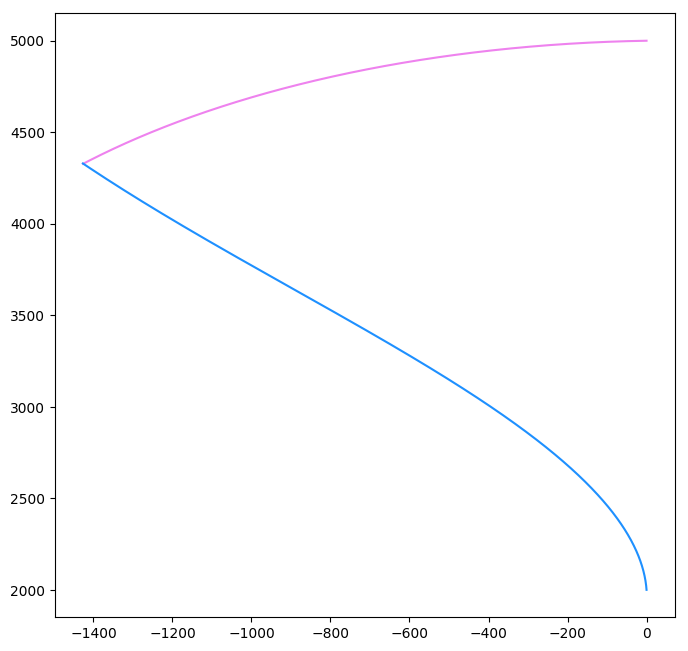

In [4]:
plt.figure(figsize=(8,8), dpi=100)
plt.plot(RT_T[:ii+1,0], RT_T[:ii+1,1], 'violet', label='target')
plt.plot(RM_T[:ii+1,0], RM_T[:ii+1,1], 'dodgerblue', label='missile')

In [5]:
# Constants
n = 3000
dt = 0.01
TT = np.zeros(1)
t = 0
D2R = ma.pi/180
R2D = 1/D2R
g = 9.81

# Dimension
Dim = 2
kkk = 5000

# Initial Target Parameters
RT = np.zeros((kkk,Dim))
RT[0,:] = [0,5000]
BETA = np.zeros(kkk)
BETA[0] = -2*D2R
VT = 200                                                 
NT = -20
BETAD = np.zeros(kkk)
BETAD[0] = NT/VT

VT_array = np.zeros((kkk,Dim))
VT_array[0,:] = [-VT*ma.cos(BETA[0]), VT*ma.sin(BETA[0])]

# Initial Missile Parameters
RM = np.zeros((kkk,Dim))
RM[0,:] = [0,2000]
VM = 300                                                              
HEDEG = -40                                                                
NP = 4                                                                     
HE = HEDEG*D2R

VM_array = np.zeros((kkk,Dim))
NC_array = np.zeros((kkk,Dim))

NCR = np.zeros((2,kkk))
NCR_array = np.zeros((kkk,Dim))
NCR_0 = NCR[0,:]

VC = np.zeros(kkk)
LAMD = np.zeros(kkk)

# noise
VC_noise = 1
LAMD_noise = 1

# autopilot
autopilot = 1

zeta = np.sqrt(2)/2
omega = 10
A = np.array([[0, 1], [-omega**2, -2*zeta*omega]])
B = np.array([[0], [omega**2]])

# additional cal
RTM_array = RT - RM
RTM = np.linalg.norm(RTM_array[0,:])
RTM_final = np.zeros(kkk)
RTM_final[0] = RTM

LAM = ma.atan2(RTM_array[0,1], RTM_array[0,0])
LEAD = ma.asin(VT * ma.sin(BETA[0] + LAM) / VM)
THET = LAM + LEAD
VM_array[0,:] = VM * ma.cos(THET + HE), VM * ma.sin(THET + HE)
VTM_array = VT_array - VM_array
VC[0] = - (RTM_array[0,:] @ VTM_array[0,:].T) / RTM
LAMD[0] = (RTM_array[0,0]*VTM_array[0,1] - RTM_array[0,1]*VTM_array[0,0]) / (RTM*RTM)

NC = np.zeros(kkk)
NC[0] = NP * VC[0] * LAMD[0]

# NC limit
if NC[0] > 4.5*g:
    NC[0] = 4.5*g
elif NC[0] < -4.5*g:
    NC[0] = -4.5*g
else:
    NC[0] = NP * VC[0] * LAMD[0]

NC_array[0,:] = [-NC[0] * ma.sin(LAM),NC[0] * ma.cos(LAM)]

NCR[:,0] = (1.5*dt*B[:,0]*NC[0])

NCR_array[0,:] = [-NCR[0,1] * ma.sin(LAM), NCR[0,1] * ma.cos(LAM)]

for i in range(1,n):
    
    BETAD[i] = NT / VT
    BETA[i] = BETA[i-1] + 0.5*dt*(3*BETAD[i] - BETAD[i-1])

    VT_array[i,:] = [-VT*ma.cos(BETA[i]), VT*ma.sin(BETA[i])]

    if i == 1:
        RT[1,:] = RT[0,:] + 1.5*dt*VT_array[0,:]

        if autopilot == 1:
            VM_array[1,:] = VM_array[0,:] + 1.5*dt*NCR_array[0,:]
        else:
            VM_array[1,:] = VM_array[0,:] + 1.5*dt*NC_array[0,:]

        RM[1,:] = RM[0,:] + 1.5*dt*VM_array[0,:]

    else:
                      
        RT[i,:] = RT[i-1,:] + 0.5*dt*(3*VT_array[i,:] - VT_array[i-1,:])
        
        if autopilot == 1:
            VM_array[i,:] = VM_array[i-1,:] + 0.5*dt*(3*NC_array[i-1,:] - NC_array[i-2,:])
        else:
            VM_array[i,:] = VM_array[i-1,:] + 0.5*dt*(3*NC_array[i-1,:] - NC_array[i-2,:])
            
        RM[i,:] = RM[i-1,:] + 0.5*dt*(3*VM_array[i,:] - VM_array[i-1,:])
        
    VTM_array = VT_array[i] - VM_array[i]
    RTM_array[i,:] = RT[i,:] - RM[i,:]
    RTM = np.linalg.norm(RTM_array[i,:])
    RTM_final[i] = RTM

    LAM = ma.atan2(RTM_array[i,1], RTM_array[i,0])
    VC[i] = - np.dot(RTM_array[i,:], VTM_array) / RTM + VC_noise * np.random.normal(0,10)
    LAMD[i] = (RTM_array[i,0]*VTM_array[1] - RTM_array[i,1]*VTM_array[0]) / (RTM*RTM) + LAMD_noise * np.random.normal(0,0.01)

    NC[i] = NP * VC[i] * LAMD[i]
    
    # NC limit
    if NC[i] > 4.5*g:
        NC[i] = 4.5*g
    elif NC[i] < -4.5*g:
        NC[i] = -4.5*g
    else:
        NC[i] = NP * VC[i] * LAMD[i]

    NC_array[i,:] = [-NC[i] * ma.sin(LAM),NC[i] * ma.cos(LAM)]
    
    if autopilot == 1:

        if i == 1:
            NCR[:,1] = (np.eye(2) + 1.5*dt*A)@NCR[:,0] + 1.5*dt*B[:,0]*NC[0]

        else:
            NCR[:,i] = (np.eye(2) + 1.5*dt*A)@NCR[:,i-1] + 1.5*dt*B[:,0]*NC[i-1] - 0.5*dt*A@NCR[:,i-2] - 0.5*dt*B[:,0]*NC[i-2]

        NCR_array[i,:] = [-NCR[0,i] * ma.sin(LAM),NCR[0,i] * ma.cos(LAM)]

        NCR_0 = NCR[0,:]

    t = t + dt
    TT = np.append(TT,t)

    # condition
    if VC[i] <= 0:
        break                 

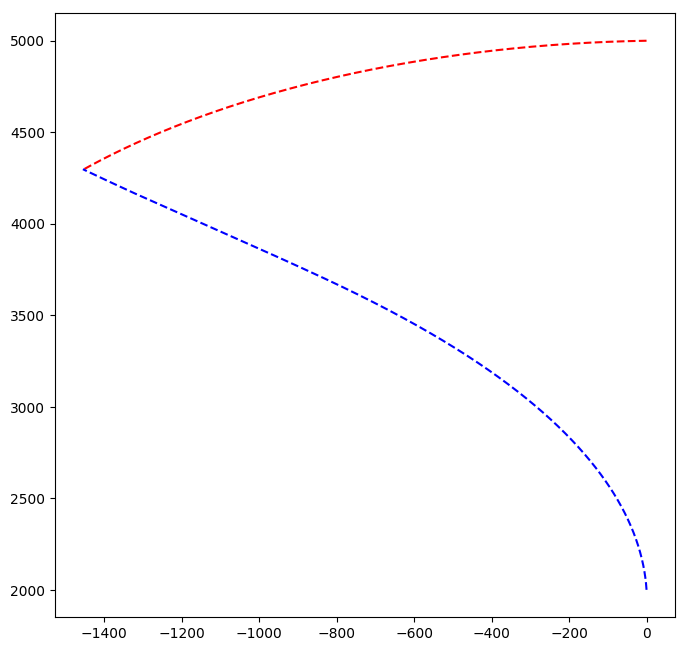

In [6]:
plt.figure(figsize=(8,8), dpi=100)
plt.plot(RT[:i+1,0], RT[:i+1,1], 'r--', label='target')
plt.plot(RM[:i+1,0], RM[:i+1,1], 'b--', label='missile')

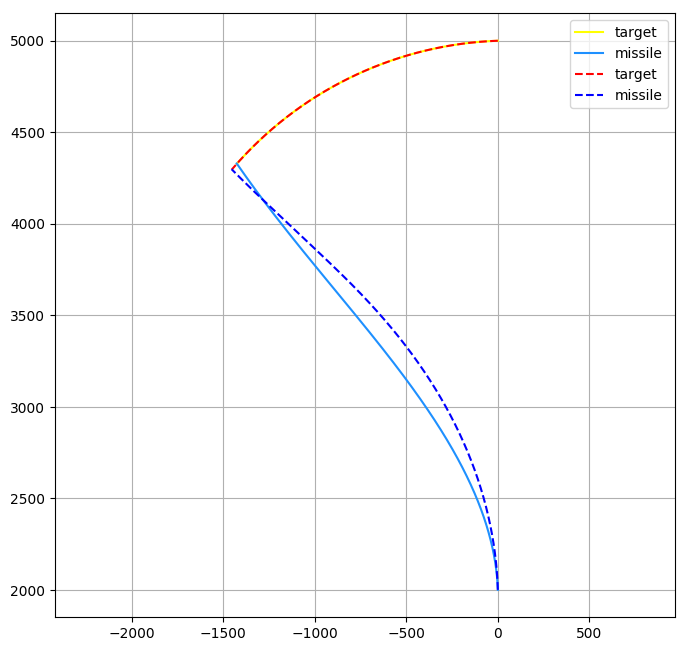

In [7]:
plt.figure(figsize=(8,8), dpi=100)
plt.plot(RT_T[:ii+1,0], RT_T[:ii+1,1], 'yellow', label='target')
plt.plot(RM_T[:ii+1,0], RM_T[:ii+1,1], 'dodgerblue', label='missile')
plt.plot(RT[:i+1,0], RT[:i+1,1], 'r--', label='target')
plt.plot(RM[:i+1,0], RM[:i+1,1], 'b--', label='missile')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

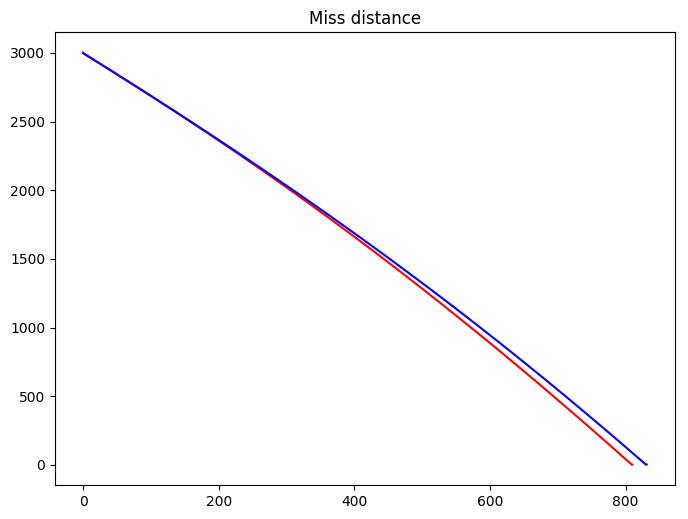

In [8]:
plt.figure(figsize=(8,6), dpi=100)
plt.title('Miss distance')
plt.plot(RTM_final_T[:ii+1], 'r', label='True')
plt.plot(RTM_final[:i+1], 'b', label='+noise')
plt.show()

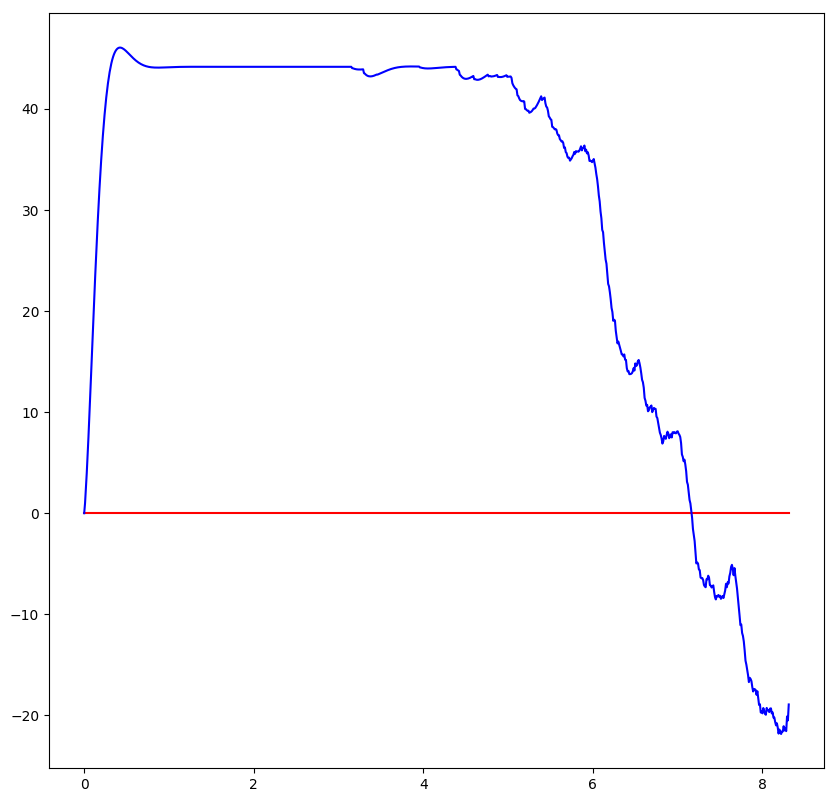

In [9]:
plt.figure(figsize=(10,10), dpi=100)
plt.plot(TT, NCR_0_T[:i+1], 'r', label='True')
plt.plot(TT, NCR_0[:i+1], 'b', label='+noise')
plt.show()

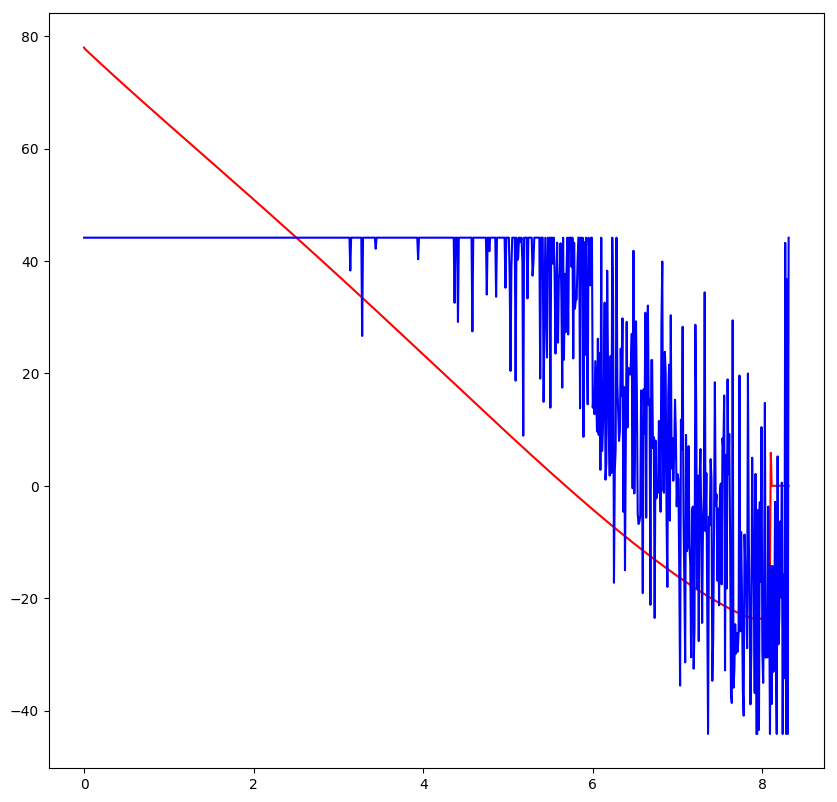

In [10]:
plt.figure(figsize=(10,10), dpi=100)
plt.plot(TT, NC_T[:i+1], 'r', label='True')
plt.plot(TT, NC[:i+1], 'b', label='+noise')